# Movie Recommender System

    author: Roman Makarov
    e-mail: o.makarov@innopolis.university

In [1]:
SAVE_PATH = '../models/model.h5' # path to save the file of the trained model
TRAIN_PATH_1 = '../reports/figures/train1.png' # path to save training graph 1
TRAIN_PATH_2 = '../reports/figures/train2.png' # path to save training graph 2

In [2]:
SAVE_PATH = 'model.h5' # path to save the file of the trained model
TRAIN_PATH_1 = 'train1.png' # path to save training graph 1
TRAIN_PATH_2 = 'train2.png' # path to save training graph 2

## Retrieving the data

Downloading the dataset from the website

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

Unzipping the dataset

In [4]:
%%capture
!unzip ml-100k.zip

## Installing required libraries and importing modules

In [5]:
%%capture
!pip install torch_geometric

In [6]:
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [7]:
import warnings
warnings.filterwarnings("ignore")

## Set up reproducibility settings

In [8]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## Defining device for faster training

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset and Preprocessing

Reading the dataset

In [10]:
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("ml-100k/u.data", sep="\t", names=columns_name)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Using only high ratings as interactions in order to predict which movies a user will enjoy watching next.

In [11]:
df = df[df['rating']>=3]
print(len(df))

82520


Splitting the dataset to train and test

In [12]:
train, test = train_test_split(df.values, test_size=0.2, random_state=SEED)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

Relabeling users and movies ids to ensure they are continuous

In [13]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

Leaving only those ids that are present in the train set and transforming them in the same way

In [14]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & \
    (test_df['item_id'].isin(train_item_ids))
]

test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

Printing resulting statistics

In [15]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1547


### Minibatch Sampling

Creating and testing a function for minibatch sampling

In [16]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
    users_df = pd.DataFrame(users, columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([ 25,  89, 104, 114, 142, 228, 250, 281, 558, 604, 654, 692, 754, 758,
         759, 913], device='cuda:0'),
 tensor([ 943, 1163, 1255, 1125, 1963, 1187, 1346, 1211, 1524, 1298, 2090, 1595,
         1243, 1123, 1053, 1322], device='cuda:0'),
 tensor([2149, 1512,  956, 1269, 2372, 1808, 1639, 1512, 1261, 1383, 1632, 1132,
         1721, 1141, 1678, 1647], device='cuda:0'))

## Edge Index

Including each edge twice to simulate undirected graph and changing the distribution of items ids so that each id is unique

In [17]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
    torch.cat([u_t, i_t]),
    torch.cat([i_t, u_t])
)).to(device)

train_edge_index

tensor([[ 108,  435,  863,  ..., 1242, 1380, 1542],
        [1099, 1490, 1499,  ...,  811,  187,  298]], device='cuda:0')

Let's confirm that the first and last edges match the middle two edges, but with the order of nodes swapped.

In [18]:
assert train_edge_index[:,-1].cpu().numpy()[::-1].all() == train_edge_index[:, len(train)-1].cpu().numpy().all()
assert train_edge_index[:, 0].cpu().numpy()[::-1].all() == train_edge_index[:, len(train)].cpu().numpy().all()

## Model Architecture

### LightGCN Convolutional Layer

Creating a class for a single LightGCN convolutional layer

In [19]:
class LightGCNConv(MessagePassing):
    """
    LightGCNConv: Graph Convolutional Layer for LightGCN Model.

    Parameters:
        aggr (str): Aggregation method for message passing. Default is 'add'.
    """

    def __init__(self, aggr='add'):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        """
        Forward pass for LightGCNConv.

        Args:
            x (torch.Tensor): Input node features.
            edge_index (torch.Tensor): Graph edge indices.

        Returns:
            torch.Tensor: Output tensor after message passing.
        """
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        """
        Message function for LightGCNConv.

        Args:
            x_j (torch.Tensor): Input tensor from neighboring nodes.
            norm (torch.Tensor): Normalization tensor.

        Returns:
            torch.Tensor: Scaled input tensor for aggregation.
        """
        return norm.view(-1, 1) * x_j

### Recommender System GNN

Creating a wrapper class for LightGCN

In [20]:
class RecSysGNN(nn.Module):
    def __init__(self, latent_dim, num_layers, num_users, num_items):
        """
        Constructor for RecSysGNN.

        Args:
            latent_dim (int): Dimension of the latent embeddings.
            num_layers (int): Number of graph convolution layers.
            num_users (int): Number of unique user IDs.
            num_items (int): Number of unique item IDs.
        """
        super(RecSysGNN, self).__init__()
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
        self.init_parameters()

    def init_parameters(self):
        """
        Initialize model parameters.

        Authors of LightGCN report higher results with normal initialization.
        """
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        """
        Forward pass for RecSysGNN.

        Args:
            edge_index (torch.Tensor): Graph edge indices.

        Returns:
            tuple: Tuple containing original embeddings and final output.
        """
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        """
        Encode a minibatch for training.

        Args:
            users (torch.Tensor): User indices.
            pos_items (torch.Tensor): Positive item indices.
            neg_items (torch.Tensor): Negative item indices.
            edge_index (torch.Tensor): Graph edge indices.

        Returns:
            tuple: Tuple containing embeddings for users, positive items, negative items,
            original embeddings for users, positive items, negative items.
        """
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

## Loss function and metrics

Implementing BPR, precision@K, recall@K, NDCG@K & MAP@K

In [21]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0):
    """
    Compute BPR loss and regularization loss.

    Args:
        users (torch.Tensor): User indices.
        users_emb (torch.Tensor): User embeddings.
        pos_emb (torch.Tensor): Positive item embeddings.
        neg_emb (torch.Tensor): Negative item embeddings.
        user_emb0 (torch.Tensor): Original user embeddings.
        pos_emb0 (torch.Tensor): Original positive item embeddings.
        neg_emb0 (torch.Tensor): Original negative item embeddings.

    Returns:
        tuple: Tuple containing BPR loss and regularization loss.
    """
    # Compute regularization loss from initial embeddings
    reg_loss = (1 / 2) * (
        user_emb0.norm().pow(2) +
        pos_emb0.norm().pow(2) +
        neg_emb0.norm().pow(2)
    ) / float(len(users))

    # Compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [22]:
def convert_to_sparse_tensor(dok_mtrx):
    """
    Convert a scipy.sparse matrix to a sparse PyTorch tensor.

    Args:
        dok_mtrx (scipy.sparse.dok_matrix): Input sparse matrix in DOK format.

    Returns:
        torch.sparse.FloatTensor: Sparse PyTorch tensor.
    """
    # Convert DOK matrix to COO format and cast to float32
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)

    # Extract values and indices
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    # Convert indices and values to PyTorch tensors
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)

    # Get the shape of the sparse tensor
    shape = dok_mtrx_coo.shape

    # Create the sparse PyTorch tensor
    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

In [23]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    """
    Compute recall and precision metrics for the recommendation model.

    Parameters:
        user_Embed_wts (torch.Tensor): User embedding weights.
        item_Embed_wts (torch.Tensor): Item embedding weights.
        n_users (int): Number of unique users.
        n_items (int): Number of unique items.
        train_data (pd.DataFrame): Training data.
        test_data (pd.DataFrame): Test data.
        K (int): Top-K recommendations.

    Returns:
        float: Mean recall value.
        float: Mean precision value.
    """

    # Initialize user and item embeddings using provided weights
    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight=user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight=item_Embed_wts)

    # Extract unique user IDs from the test data
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # Compute relevance scores using matrix multiplication
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    # Create a sparse matrix R based on training data interactions
    R = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    # Convert sparse matrix R to a sparse PyTorch tensor
    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    # Set interactions in R_tensor_dense to negative infinity
    R_tensor_dense = R_tensor_dense * (-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0).to(device)

    # Add R_tensor_dense to relevance scores
    relevance_score = relevance_score + R_tensor_dense

    # Get top-K relevance scores and indices
    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    # Create a DataFrame for top-K relevance indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),
                                              columns=['top_indx_' + str(x + 1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index

    # Create a column with top-K relevant items
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[
        ['top_indx_' + str(x + 1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID', 'top_rlvnt_itm']]

    # Group test data by user ID and extract lists of interacted items
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # Merge top-K relevance indices with test interacted items
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df, how='left', left_on='user_id_idx',
                          right_on=['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in
                                  zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    # Compute recall and precision
    metrics_df['recall'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / len(x['item_id_idx']), axis=1)
    metrics_df['precision'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / K, axis=1)

    # Return mean values of recall, precision, nDCG, and MAP
    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## Train and evaluate models

In [24]:
latent_dim = 256
n_layers = 4

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [25]:
def train_and_eval(model, optimizer, train_df):
    """
    Train the model and evaluate its performance over multiple epochs.

    Args:
        model (RecSysGNN): The recommendation system GNN model.
        optimizer (torch.optim.Optimizer): The optimizer for training the model.
        train_df (pd.DataFrame): Training data.
        test_df (pd.DataFrame): Test data.
        train_edge_index (torch.Tensor): Edge index for training.
        n_users (int): Number of unique users.
        n_items (int): Number of unique items.
        K (int): Top-K recommendations.

    Returns:
        tuple: Tuple containing lists of loss values, recall, and precision.
    """
    # Lists to store metrics across epochs
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []
    recall_list = []
    precision_list = []

    # Training loop over epochs
    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train_df) / BATCH_SIZE)

        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []

        # Set the model to training mode
        model.train()

        # Batch-wise training loop
        for batch_idx in range(n_batch):
            optimizer.zero_grad()

            # Generate a minibatch of data
            users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

            # Compute BPR loss and regularization loss
            bpr_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            # Backward pass and optimization step
            final_loss.backward()
            optimizer.step()

            # Append loss values to lists
            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        # Evaluation on test set after each epoch
        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall, test_topK_precision = get_metrics(
                final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
            )

        # Append metrics to corresponding lists
        loss_list_epoch.append(round(np.mean(final_loss_list), 4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list), 4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))
        recall_list.append(round(test_topK_recall, 4))
        precision_list.append(round(test_topK_precision, 4))

    # Return a tuple containing lists of metrics
    return (
        loss_list_epoch,
        bpr_loss_list_epoch,
        reg_loss_list_epoch,
        recall_list,
        precision_list
    )

### Train LightGCN

In [26]:
# Instantiate the RecSysGNN model
lightgcn = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
).to(device)

# Initialize the Adam optimizer for training the model
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

# Print the size of learnable parameters in the model
print("Size of Learnable Embedding : ", [x.shape for x in lightgcn.parameters()])

Size of Learnable Embedding :  [torch.Size([2490, 256])]


In [27]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [28]:
epoch_list = [(i+1) for i in range(EPOCHS)]

## Plotting training graphs information

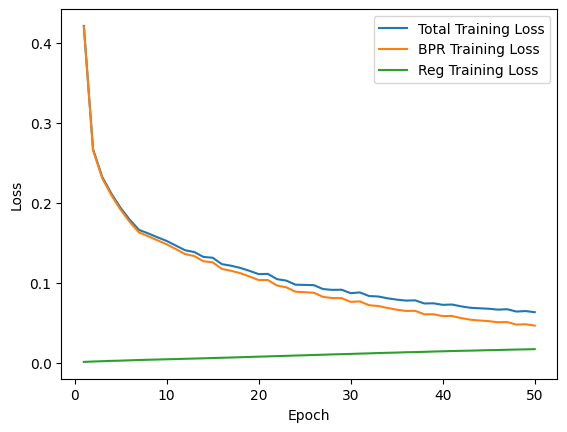

In [29]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(TRAIN_PATH_1, bbox_inches="tight")

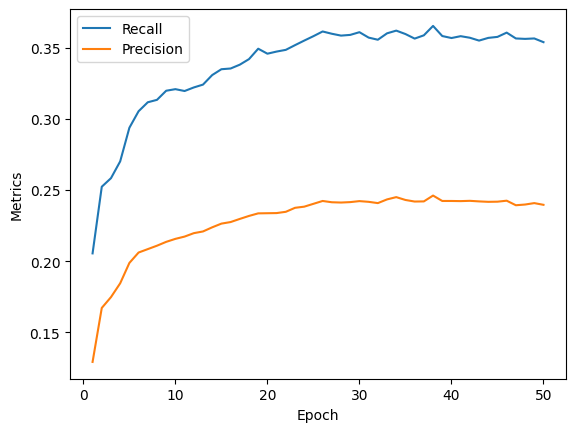

In [30]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.savefig(TRAIN_PATH_2, bbox_inches="tight")

# Saving the model

In [31]:
torch.save(lightgcn.state_dict(), SAVE_PATH)

# Cleaning up the directory

In [32]:
!rm -rf ml-100k.zip
!rm -rf ml-100k